In [1]:
from matplotlib.gridspec import GridSpec
from matplotlib import cm

import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit, learning_curve
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC

from sklearn.metrics import accuracy_score, precision_score, recall_score, \
                            precision_recall_curve, f1_score, confusion_matrix, roc_curve, \
                            roc_auc_score

from IPython.display import HTML

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from library import *
%matplotlib inline



# Loading the data

In [2]:
df = pd.read_csv('datatransformed.csv', index_col=0, parse_dates=True)

# Preparing the data

In [3]:
df.isnull().sum()

rating             0
anciennete       185
v1                 0
v2            602630
v3                 8
v4                 0
v5                 0
v6                 0
v7            571076
v8            599476
cible              0
dtype: int64

In [4]:
df.v8 = df.v8.replace([np.NaN],[0], inplace=False)
original_size = len(df)
df = df.dropna(axis=0)
after_size = len(df)

print(f'With this approach, we have lost {100 - 100*(after_size/original_size):.2f}% of the data \
({original_size-after_size} samples).')

With this approach, we have lost 95.62% of the data (682444 samples).


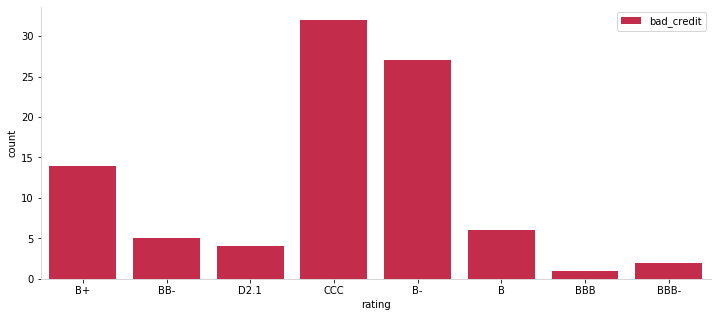

In [5]:
risk_good = df.loc[df['cible'] == 'good']
risk_bad = df.loc[df['cible'] == 'bad']
fig, ax = plt.subplots(figsize=(12, 5))
ax = sns.countplot(risk_bad['rating'], label='bad_credit', color='crimson')
ax.patch.set_facecolor('#FFFFFF')
format_spines(ax, right_border=False)
plt.legend()
plt.show()

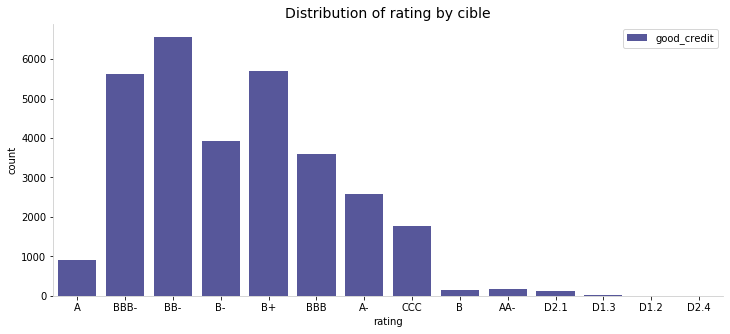

In [6]:
fig, ax = plt.subplots(figsize=(12, 5))
ax = sns.countplot(risk_good['rating'], label='good_credit', color='navy', alpha=0.7)
ax.set_title(f'Distribution of rating by cible', size=14)
ax.patch.set_facecolor('#FFFFFF')
format_spines(ax, right_border=False)
plt.legend()
plt.show()

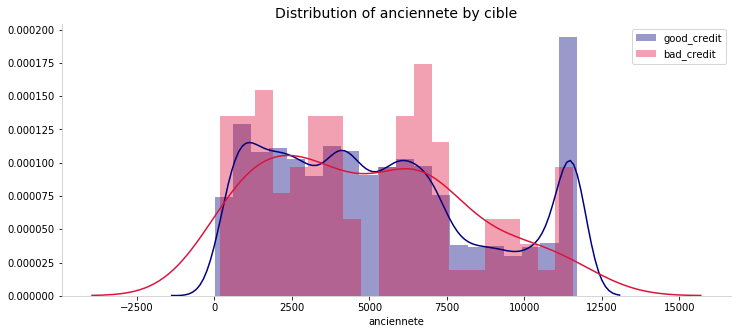

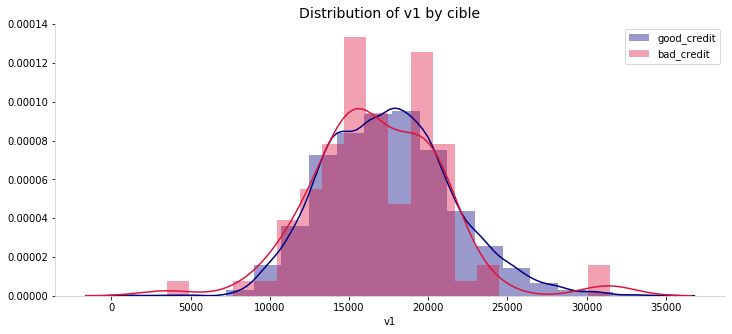

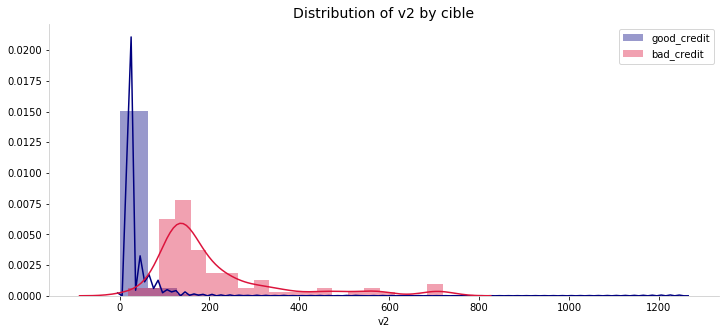

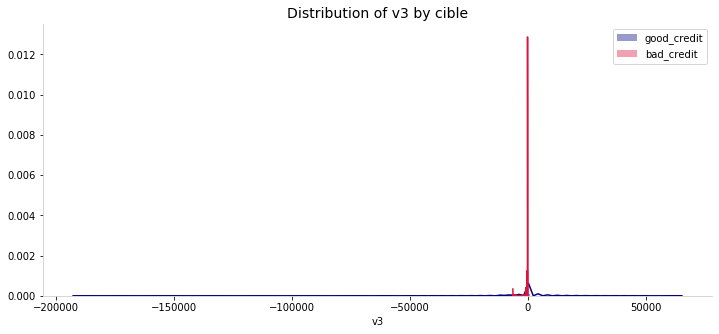

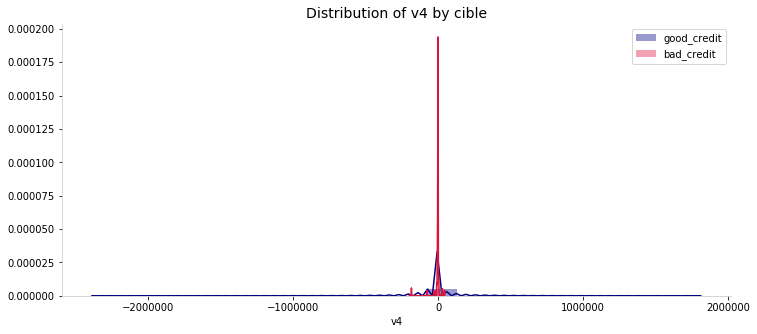

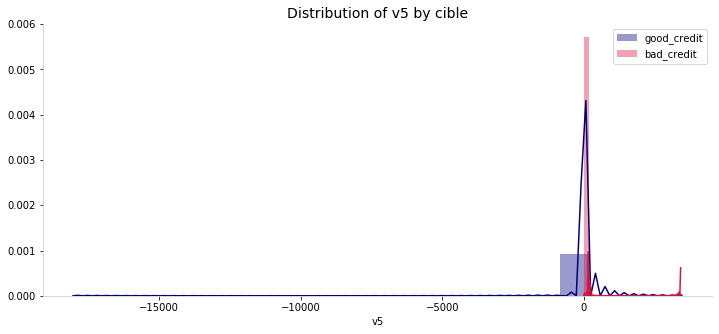

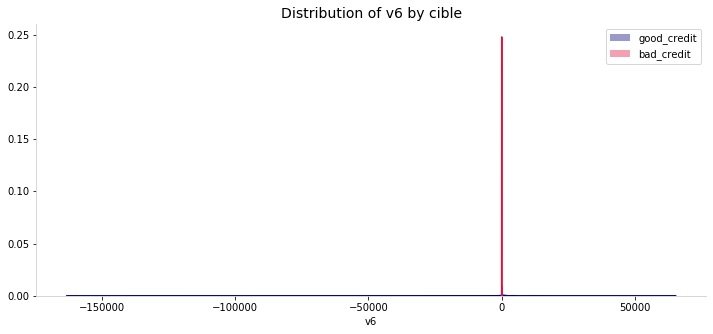

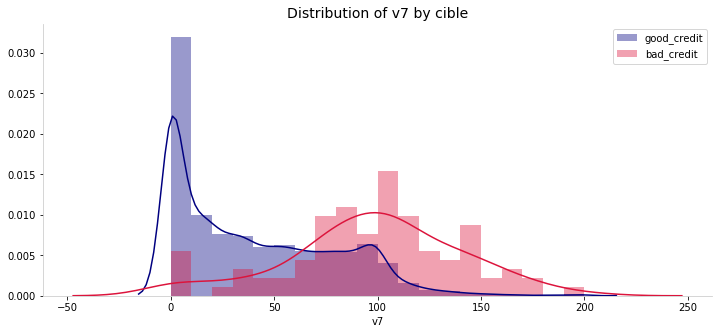

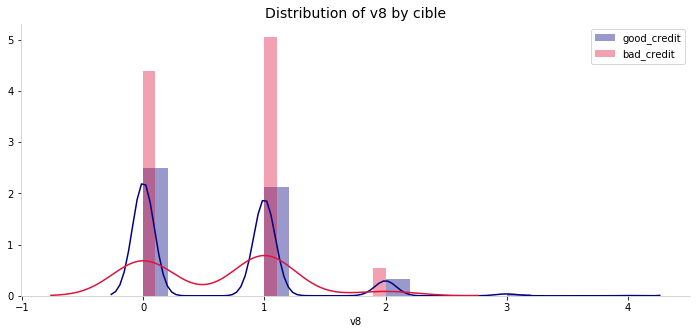

In [7]:
for i in df.columns[1:-1]:
    fig, ax = plt.subplots(figsize=(12, 5))
    risk_good = df.loc[df['cible'] == 'good']
    risk_bad = df.loc[df['cible'] == 'bad']
    ax = sns.distplot(risk_good[i], bins=20, label='good_credit', color='navy')
    ax = sns.distplot(risk_bad[i], bins=20, label='bad_credit', color='crimson')
    ax.set_title(f'Distribution of {i} by cible', size=14)
    ax.patch.set_facecolor('#FFFFFF')
    format_spines(ax, right_border=False)
    plt.legend()
    plt.show()

In [8]:
# Indexing data
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Changing label
y = (y == 'bad')*1

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.50, random_state=42)

print(f'X_train dimension: {X_train.shape}')
print(f'X_test dimension: {X_test.shape}')
print(f'\ny_train dimension: {y_train.shape}')
print(f'y_test dimension: {y_test.shape}')

X_train dimension: (15625, 10)
X_test dimension: (15626, 10)

y_train dimension: (15625,)
y_test dimension: (15626,)


In [59]:
# categorical variables
cat_attribs = ['rating','v8']
# Categories of the categorical variables
categories = [np.unique(df[cat]) for cat in cat_attribs]
# Numerical variables
num_attribs = df.columns[1:-2]

# Models to be used
classifiers = {
    'log_reg': LogisticRegression(),
    'tree_clf': DecisionTreeClassifier(),
    'forest_clf': RandomForestClassifier(),
    'svm_clf': SVC(probability=True),
    'knn_clf': KNeighborsClassifier(),
    'mlp_clf': MLPClassifier()
}



# Preparing pipeline
full_pipeline = create_pipelines(num_attribs, cat_attribs, categories)

# Preparing data
X_train_prepared = full_pipeline.fit_transform(X_train)


# =============================================================================
# Training the models
# =============================================================================

trained_models = {}

for key, model in classifiers.items():
    model.fit(X_train_prepared, y_train)
    trained_models[key] = model


# Creating dataframe to hold metrics
train_performance = create_dataset()

# Evaluating models
train_performance = model_analysis(trained_models, X_train_prepared, y_train, train_performance)

## Result (for jupyter nootbook)
cm = sns.light_palette("cornflowerblue", as_cmap=True)
train_performance.style.background_gradient(cmap=cm)
#print(train_performance)

,acc,prec,rec,f1,auc,total_time
log_reg,0.9965,0.1167,0.0422,0.0619,0.9473,3.453
tree_clf,0.9948,0.201,0.2022,0.2331,0.6108,1.752
forest_clf,0.9969,0.2333,0.08,0.0949,0.9153,27.339
svm_clf,0.9969,0,0,0,0.8564,57.131
knn_clf,0.9967,0.1,0.0222,0.0364,0.75,33.279
mlp_clf,0.9964,0.05,0.06,0.0671,0.9591,131.887


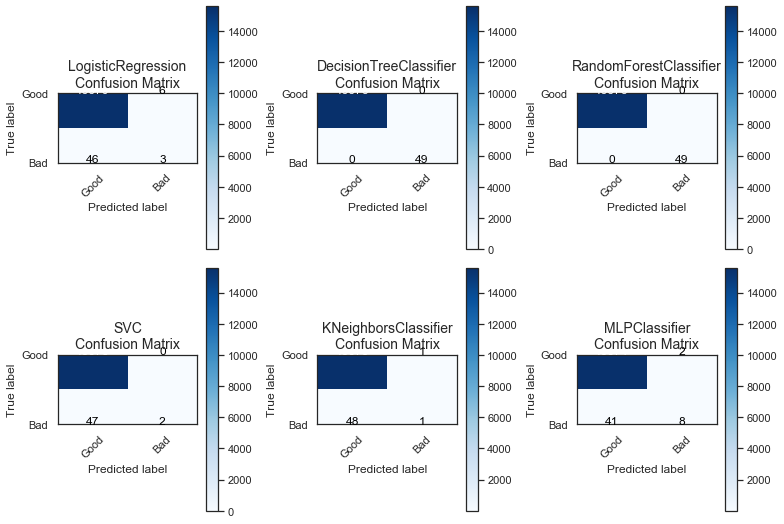

In [12]:
model_confusion_matrix(trained_models, X_train_prepared, y_train)

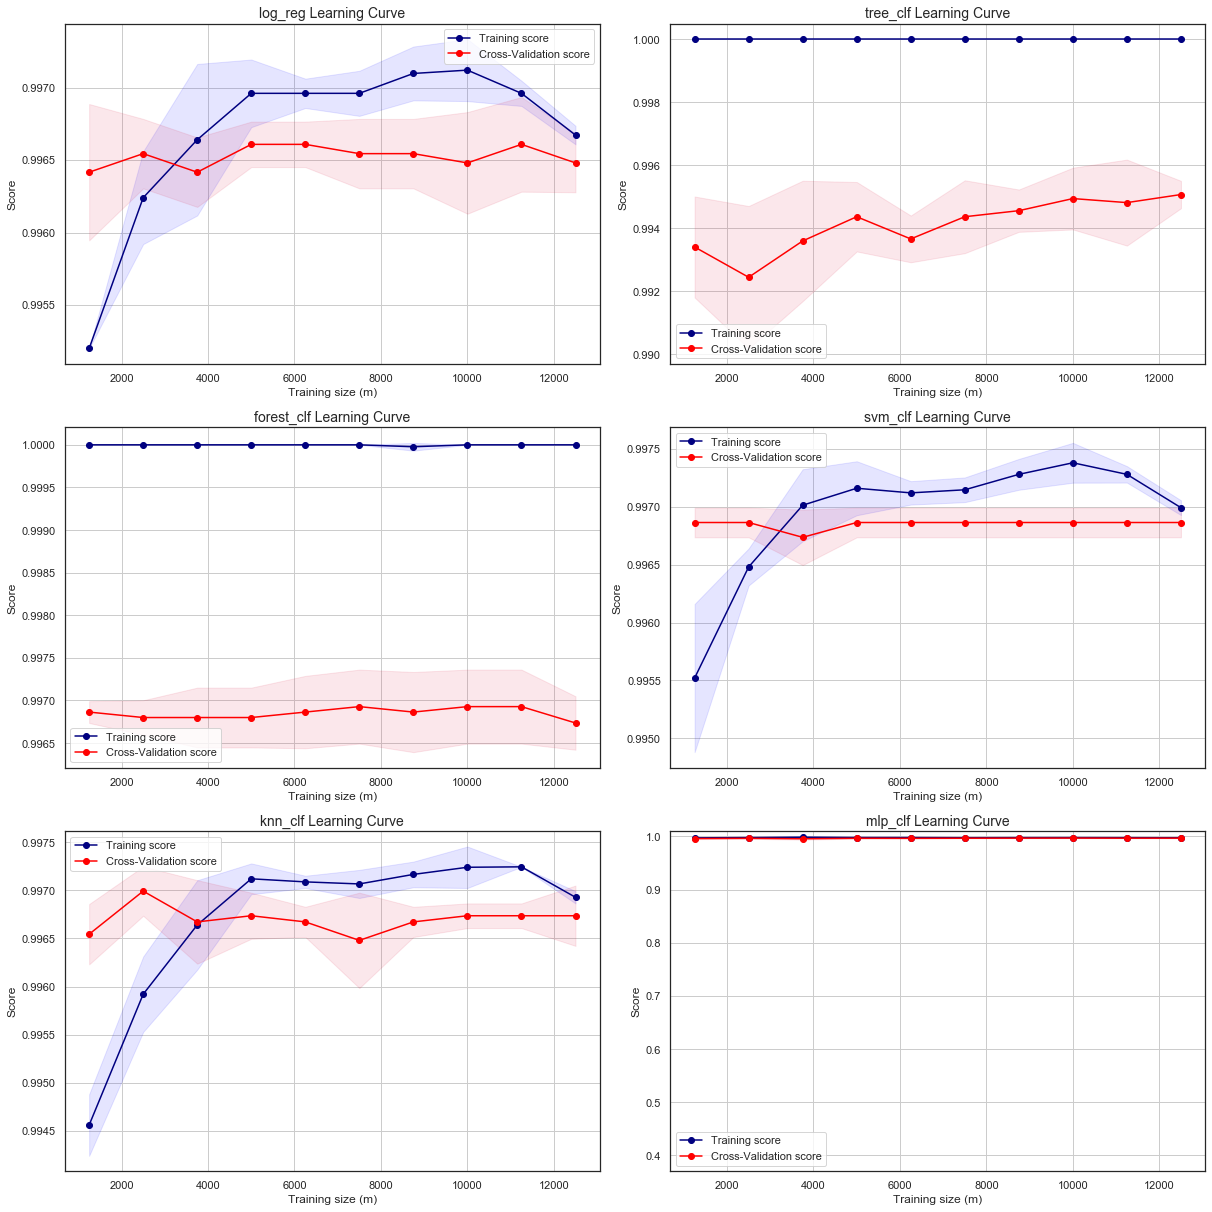

In [13]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(trained_models, X_train_prepared, y_train, (0.37, 1.01), cv=5, n_jobs=4)
plt.tight_layout()

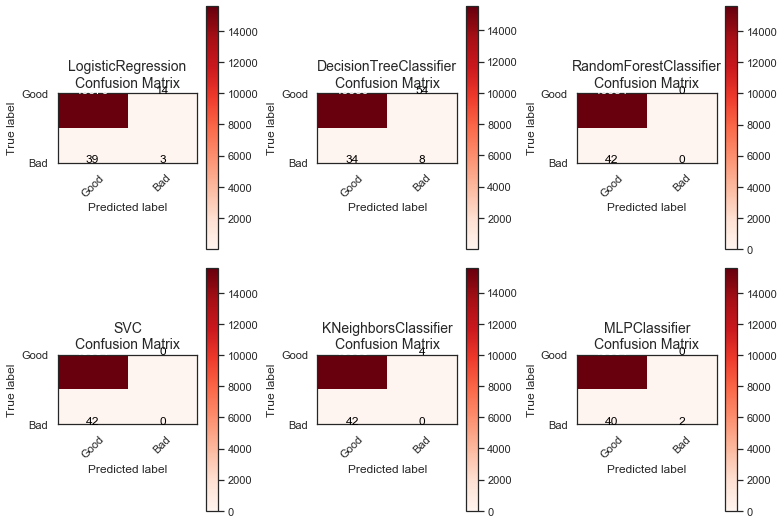

In [15]:
# Test set evaluation
X_test_prepared = full_pipeline.fit_transform(X_test)
model_confusion_matrix(trained_models, X_test_prepared, y_test.values, cmap=plt.cm.Reds)

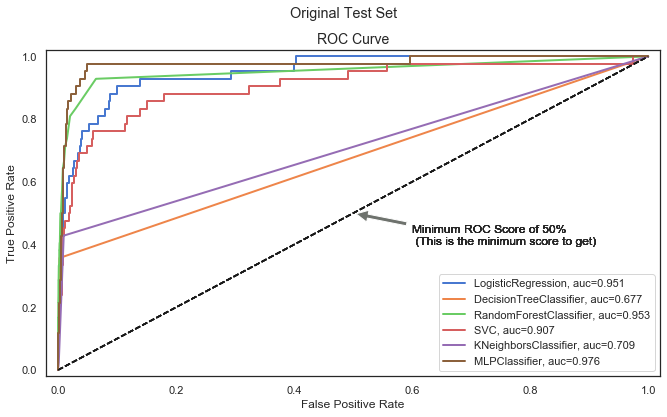

In [16]:
# ROC
plt.figure(figsize=(11, 6))

for key, model in trained_models.items():

    # Computing scores with cross_val_predict
    try:
        y_scores = cross_val_predict(model, X_test_prepared, y_test, cv=5,
                                     method='decision_function')
    except:
        # Trees don't have decision_function but predict_proba
        y_probas = cross_val_predict(model, X_test_prepared, y_test, cv=5,
                                     method='predict_proba')
        y_scores_tree = y_probas[:, 1]
        y_scores = y_scores_tree

    # ROC Curve
    model_name = model.__class__.__name__
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    auc = roc_auc_score(y_test, y_scores)
    plot_roc_curve(fpr, tpr, y_test, y_scores, auc, label=model_name)
    plt.suptitle('Original Test Set')

# Improvements: Increasing the defaults

Total good credit risk: 31160
Total bad credit risk: 91


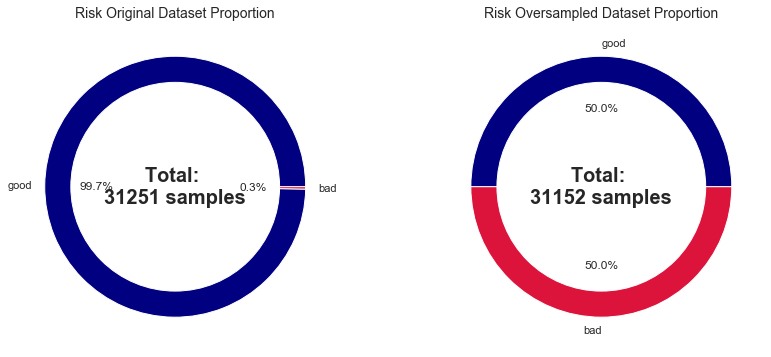

In [20]:
good_credit = df.query('cible == "good"')
bad_credit = df.query('cible == "bad"')
print(f'Total good credit risk: {len(good_credit)}')
print(f'Total bad credit risk: {len(bad_credit)}')

X = df.iloc[:, :-1]
y = df.iloc[:, -1]
y = (y == 'bad')*1

X_train_imp3, X_test_imp3, y_train_imp3, y_test_imp3 = \
    train_test_split(X, y, test_size=.50, random_state=42)

# Increasing the defaults
positions = df.columns == ""
for atr in cat_attribs:
    positions += atr == df.columns
    
cat_attribs_idx = np.arange(len(df.columns))[positions]

sm = SMOTENC(categorical_features=cat_attribs_idx, sampling_strategy='minority', random_state=43)
X_train_res, y_train_res = sm.fit_resample(X_train_imp3, y_train_imp3)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
donut_plot('cible', df=df, text=f'Total: \n{str(len(df))} samples', ax=axs[0])
axs[0].set_title('Risk Original Dataset Proportion', size=14)
df_risk_over = pd.DataFrame(y_train_res, columns=['cible'])
donut_plot('cible', df=df_risk_over, text=f'Total: \n{str(len(df_risk_over))} samples', ax=axs[1])
axs[1].set_title('Risk Oversampled Dataset Proportion', size=14)
plt.show()

In [21]:
# Transform the new data
X_train_prepared_imp3 = full_pipeline.fit_transform(X_train_res)
X_test_prepared_imp3 = full_pipeline.fit_transform(X_test_imp3)


# Training the models

trained_models_imp3 = {}
for key, model in classifiers.items():
    model.fit(X_train_prepared_imp3, y_train_res)
    trained_models_imp3[key] = model

# Creating dataframe to hold metrics
train_performance_imp3 = create_dataset()

# Evaluating models
train_performance_imp3 = model_analysis(trained_models_imp3,
                                        X_train_prepared_imp3, y_train_res, train_performance_imp3)

               acc    prec     rec      f1     auc  total_time
log_reg     0.9693  0.9636  0.9755  0.9695  0.9906      10.369
tree_clf    0.9933  0.9905  0.9954  0.9932  0.9936      21.914
forest_clf  0.9965  0.9934  0.9997  0.9964  0.9999     151.362
svm_clf     0.9850  0.9753  0.9952  0.9852  0.9958     247.363
knn_clf     0.9907  0.9823  0.9994  0.9908  0.9959     157.240
mlp_clf     0.9938  0.9892  0.9988  0.9942  0.9984    1005.479


In [22]:
## Improvement 3 results - Oversampling
cm = sns.light_palette("crimson", as_cmap=True)
train_performance_imp3.style.background_gradient(cmap=cm)
#print(train_performance_imp3)

,acc,prec,rec,f1,auc,total_time
log_reg,0.9693,0.9636,0.9755,0.9695,0.9906,10.369
tree_clf,0.9933,0.9905,0.9954,0.9932,0.9936,21.914
forest_clf,0.9965,0.9934,0.9997,0.9964,0.9999,151.362
svm_clf,0.985,0.9753,0.9952,0.9852,0.9958,247.363
knn_clf,0.9907,0.9823,0.9994,0.9908,0.9959,157.24
mlp_clf,0.9938,0.9892,0.9988,0.9942,0.9984,1005.48


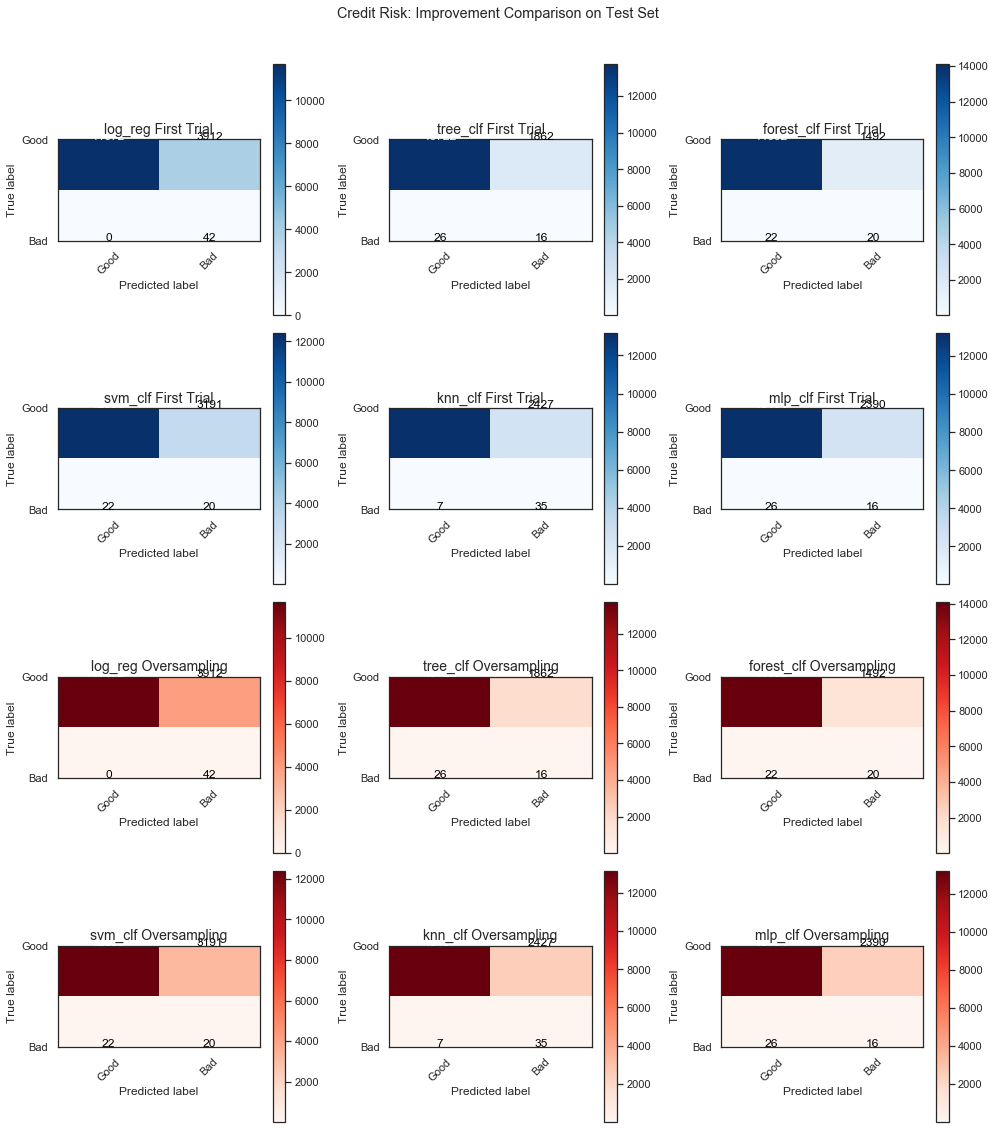

In [24]:
labels = ['Good', 'Bad']
titles = ['First Trial', 'Oversampling']

models_to_predict = trained_models
models_to_predict_imp3 = trained_models_imp3

plt.figure(figsize=(14, 16))
sns.set(style='white', palette='muted', color_codes=True)
i = 1

for key, model in models_to_predict.items():
    prediction = model.predict(X_test_prepared)
    cf_mx_first_trial = confusion_matrix(y_test, prediction)
    plt.subplot(4, 3, i)
    plot_confusion_matrix(cf_mx_first_trial, labels, title=key+' '+titles[0], cmap=plt.cm.Blues)
    i += 1

for key, model in models_to_predict_imp3.items():
    prediction_imp3 = model.predict(X_test_prepared_imp3)
    cf_mx_imp3 = confusion_matrix(y_test_imp3, prediction_imp3)
    plt.subplot(4, 3, i)
    plot_confusion_matrix(cf_mx_imp3, labels, title=key+' '+titles[1], cmap=plt.cm.Reds)
    i += 1

plt.tight_layout()
plt.suptitle('Credit Risk: Improvement Comparison on Test Set')
plt.subplots_adjust(top=0.93)
plt.show()

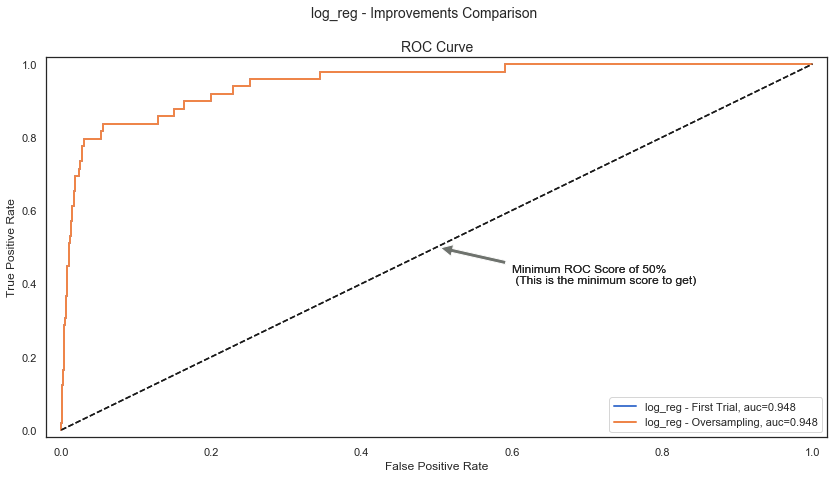

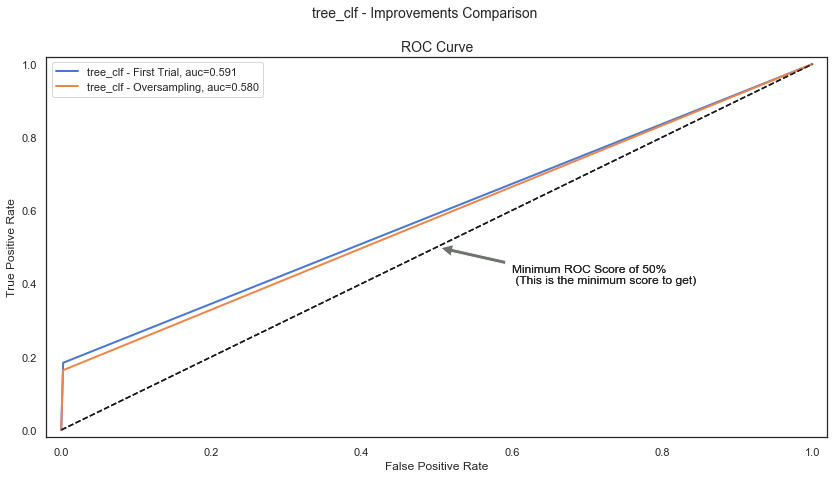

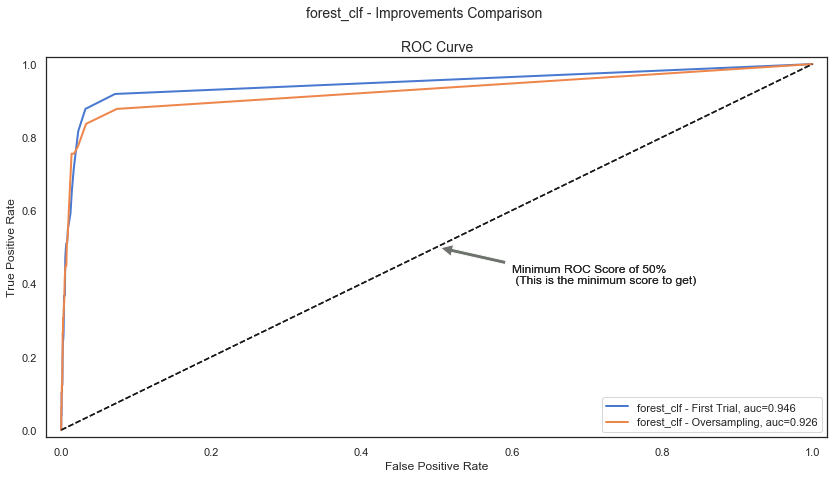

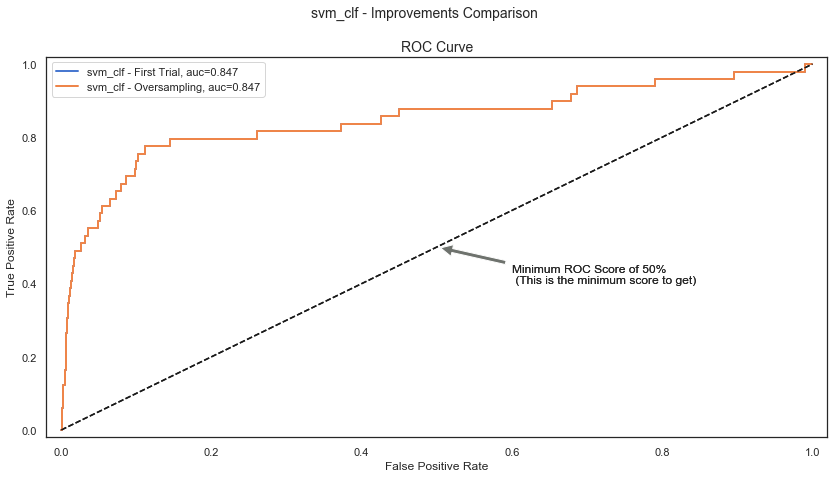

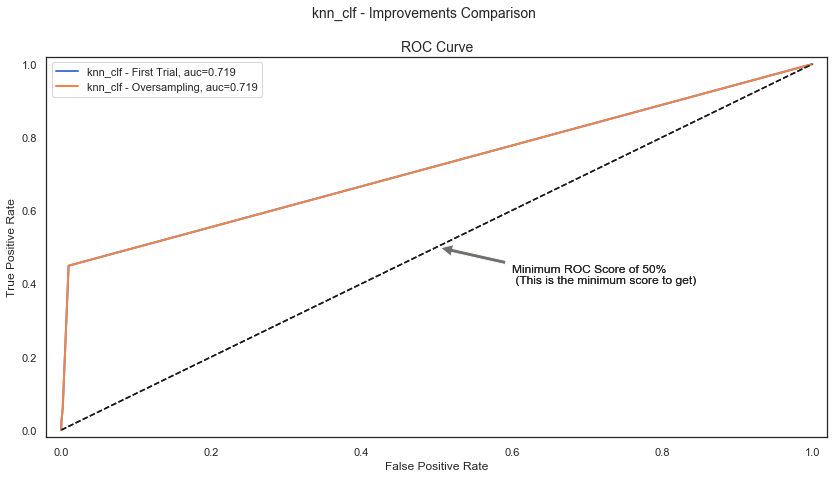

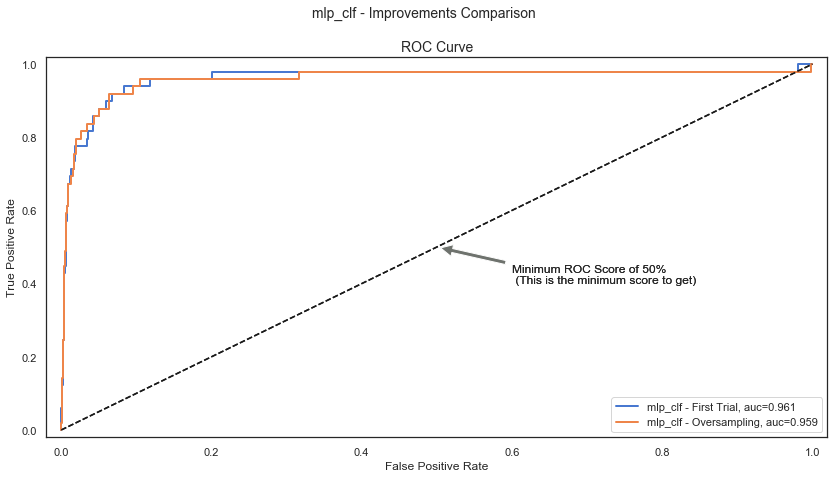

In [25]:
base = dict_analysis(train_set = X_train_prepared,
              y_train = y_train,
              test_set = X_test_prepared,
              y_test = y_test,
              train_set_imp = X_train_prepared,
              y_train_imp = y_train,
              test_set_imp = X_test_prepared_imp3,
              y_test_imp = y_test_imp3
             )

# Compute ROC 
for model_to_compare in trained_models.keys():
    base.update_dict(model_to_compare, trained_models, trained_models_imp3)
    roc_comparison_log_reg = base.generate_analysis()

    plt.figure(figsize=(14, 7))
    for outter_key, outter_dict in roc_comparison_log_reg.items():
        try:
            y_scores = cross_val_predict(outter_dict['model'], outter_dict['train_set'],
                                         outter_dict['y_train'], cv=10, method='decision_function')
        except:
            # Trees don't have decision_function but predict_proba
            y_probas = cross_val_predict(outter_dict['model'], outter_dict['train_set'],
                                     outter_dict['y_train'], cv=10, method='predict_proba')
            y_scores_tree = y_probas[:, 1]
            y_scores = y_scores_tree

        fpr, tpr, thresholds = roc_curve(outter_dict['y_train'], y_scores)
        auc = roc_auc_score(outter_dict['y_train'], y_scores)
        plot_roc_curve(fpr, tpr, outter_dict['y_train'], y_scores, auc, label=outter_dict['model_name'])
        plt.suptitle(model_to_compare + ' - Improvements Comparison', size=14)

In [60]:
sample = np.random.randint(len(X_test_prepared), size=5)
for model in trained_models_imp3:
    print(trained_models_imp3[model].predict_proba(X_test_prepared))


[[9.99914289e-01 8.57105324e-05]
 [3.83260297e-07 9.99999617e-01]
 [1.37381065e-01 8.62618935e-01]
 ...
 [9.92587019e-01 7.41298081e-03]
 [9.97123403e-01 2.87659689e-03]
 [6.27394619e-01 3.72605381e-01]]
[[1. 0.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[[0.94 0.06]
 [0.64 0.36]
 [0.58 0.42]
 ...
 [0.91 0.09]
 [0.96 0.04]
 [0.76 0.24]]


AttributeError: predict_proba is not available when  probability=False